In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import fft
from tqdm.auto import tqdm

from nalger_helper_functions import *

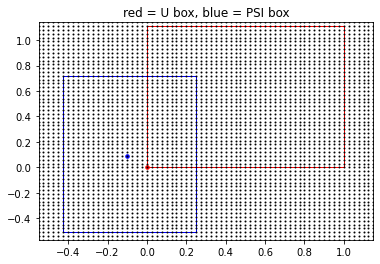

In [2]:
hh = np.array([0.025, 0.03]) * 1.0

U_centerpoint = np.zeros(2)
min_U, max_U, U_shape = conforming_box(np.array([0., 0.]), np.array([1., 1.1]), U_centerpoint, hh)

PSI_centerpoint = np.round(np.array([-0.1, 0.1]) / hh) * hh
min_PSI, max_PSI, PSI_shape = conforming_box(np.array([-0.4, -0.5]), np.array([0.23, 0.7]), PSI_centerpoint, hh)

min_plot, max_plot, plot_shape = conforming_box(np.min([min_U, min_PSI])-hh, np.max([max_U, max_PSI])+hh, 
                                                np.zeros(2), hh)

d = len(min_PSI)

_, (XPSI, YPSI) = make_regular_grid(min_PSI, max_PSI, PSI_shape)
_, (XU, YU) = make_regular_grid(min_U, max_U, U_shape)
_, (X, Y) = make_regular_grid(min_plot, max_plot, plot_shape)

plt.figure()

r1 = plot_rectangle(min_U, max_U, edgecolor='r')
plt.plot(U_centerpoint[0], U_centerpoint[1], '.r', markersize=7)

r2 = plot_rectangle(min_PSI, max_PSI, edgecolor='b')
plt.plot(PSI_centerpoint[0], PSI_centerpoint[1], '.b', markersize=7)

plt.plot(X[:], Y[:], '.k', markersize=2)

plt.xlim(min_plot[0], max_plot[0])
plt.ylim(min_plot[1], max_plot[1])

plt.title('red = U box, blue = PSI box')

plt.show()

In [3]:
def make_2D_grid_gaussian(mu, Sigma, X, Y):
    d = len(X.shape)
    C = np.power(2 * np.pi, -d/2.) * np.power(np.linalg.det(Sigma), -1./2.)
    
    zz = np.vstack([X.reshape(-1), Y.reshape(-1)]) - mu.reshape((-1,1))
    F = C * np.exp(-0.5 * np.sum(zz * np.linalg.solve(Sigma, zz), axis=0).reshape(-1)).reshape(X.shape)
    return F

PSI(np.zeros(2))= [19.33068653]
PSI_sum= 14.862298882603447
nonsymmetry= 1.6709698630644851


/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:184: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.array)


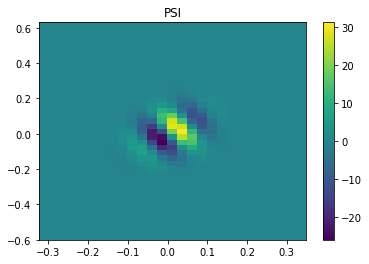

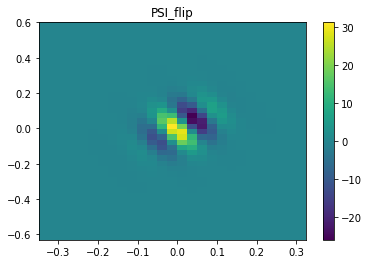

In [4]:
mu = PSI_centerpoint
Sigma = np.array([[0.004, 0.0015], 
                  [0.0015, 0.011]])*0.7

# PSI_data = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI)
# PSI_data = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI) * np.sin(40*XPSI + 16*YPSI)**2 * 1.
PSI_data = make_2D_grid_gaussian(mu, Sigma, XPSI, YPSI) * np.sin(40*XPSI + 16*YPSI) * -1.

PSI = BoxFunction(min_PSI, max_PSI, PSI_data).translate(-PSI_centerpoint)

# PSI.array[tuple(PSI.zeropoint_index)] = 4.468387651296901
print('PSI(np.zeros(2))=', PSI(np.zeros(2)))

PSI_sum = np.sum(PSI.array)
print('PSI_sum=', PSI_sum)

# PSI = (PSI + PSI.flip()) / 2. # make symmetric

nonsymmetry = boxnorm(PSI - PSI.flip()) / boxnorm(PSI)
print('nonsymmetry=', nonsymmetry)

PSI_flip = PSI.flip()

PSI.plot(title='PSI')
PSI_flip.plot(title='PSI_flip')

Z_imag_fraction= 2.8298851208097267e-07


/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:169: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.array.real)
/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:175: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.array.imag)


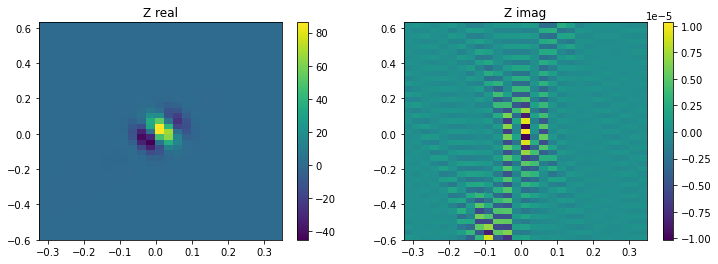

In [5]:
Z = convolution_square_root(PSI, positive_real_branch_cut=np.pi, negative_real_branch_cut=0.0,
                           pre_expansion=1, post_contraction=1)

Z_imag_fraction = boxnorm(Z.imag) / boxnorm(Z)
print('Z_imag_fraction=', Z_imag_fraction)

Z.plot(title='Z')

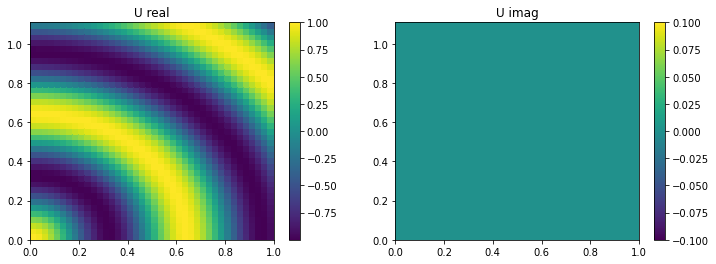

In [6]:
U_data = np.cos(10*np.sqrt(XU**2 + YU**2))

U = BoxFunction(min_U, max_U, U_data).translate(-U_centerpoint).astype('complex')

U.plot(title='U')

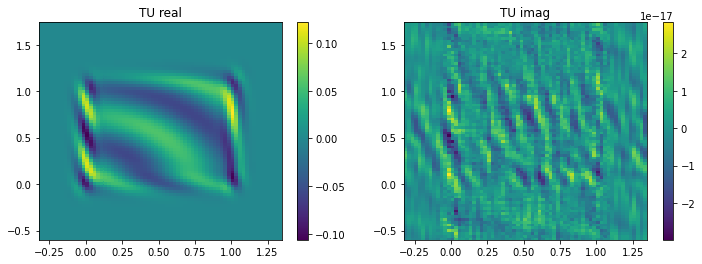

In [7]:
TU = boxconv(PSI, U)

TU.plot(title='TU')

In [8]:
build_dense=False

if build_dense:
    def convolve_with_Z(x):
        X = BoxFunction(U.min, U.max, x.reshape(U.shape))
        Y = boxconv(Z, X).restrict_to_new_box(U.min, U.max)
        return Y.array.reshape(-1)

    n = np.prod(U.shape)
    T = np.zeros((n,n), dtype='complex')
    for k in tqdm(range(n)):
        ek = np.zeros(n, dtype='complex')
        ek[k] = 1.
        T[:,k] = convolve_with_Z(ek)

    Z_star = Z.flip().conj()
    def convolve_with_Z_star(x):
        X = BoxFunction(U.min, U.max, x.reshape(U.shape))
        Y = boxconv(Z_star, X).restrict_to_new_box(U.min, U.max)
        return Y.array.reshape(-1)

    T_star = np.zeros((n,n), dtype='complex')
    for k in tqdm(range(n)):
        ek = np.zeros(n, dtype='complex')
        ek[k] = 1.
        T_star[:,k] = convolve_with_Z_star(ek)

    def convolve_with_PSI(x):
        X = BoxFunction(U.min, U.max, x.reshape(U.shape))
        Y = boxconv(PSI, X).restrict_to_new_box(U.min, U.max)
        return Y.array.reshape(-1)

    H = np.zeros((n,n), dtype='complex')
    for k in tqdm(range(n)):
        ek = np.zeros(n, dtype='complex')
        ek[k] = 1.
        H[:,k] = convolve_with_PSI(ek)

    np.linalg.norm(T.T.conj() - T_star) / np.linalg.norm(T)

    TT = T @ T

    err_TT_minus_H = np.linalg.norm(TT - H) / np.linalg.norm(H)
    print('err_TT_minus_H=', err_TT_minus_H)

    T_star_T = T_star @ T

    err_T_star_T_minus_H = np.linalg.norm(T_star_T - H) / np.linalg.norm(H)
    err_T_star_T_plus_H = np.linalg.norm(T_star_T + H) / np.linalg.norm(H)
    err_T_star_T_minus_Hsym = np.linalg.norm(T_star_T - (H+H.T)/2.) / np.linalg.norm(H)
    err_T_star_T_plus_Hsym = np.linalg.norm(T_star_T + (H+H.T)/2.) / np.linalg.norm(H)

    print('err_T_star_T_minus_H=', err_T_star_T_minus_H, ', err_T_star_T_plus_H=', err_T_star_T_plus_H)
    print('err_T_star_T_minus_Hsym=', err_T_star_T_minus_Hsym, ', err_T_star_T_plus_Hsym=', err_T_star_T_plus_Hsym)

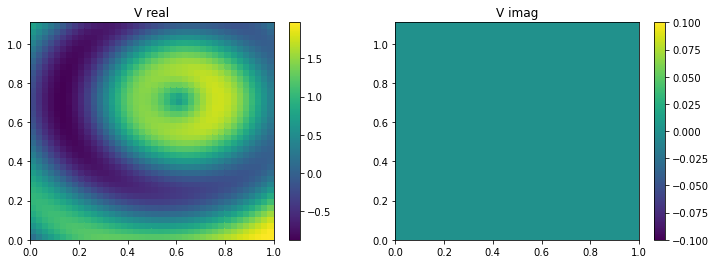

In [9]:
V_data = np.sin(10*np.sqrt((XU-0.6)**2 + (YU - 0.7)**2)) + XU

V = BoxFunction(min_U, max_U, V_data).translate(-U_centerpoint).astype('complex')

V.plot(title='V')

In [10]:
ip1 = boxinner(boxconv(Z, U), V)
ip2 = boxinner(U, boxconv(Z.flip().conj(), V))
err_adj = np.abs((ip1 - ip2) / ip1)
print('err_adj=', err_adj)

err_adj= 1.1060708487138228e-14


err_sqrt= 0.005336070752655081


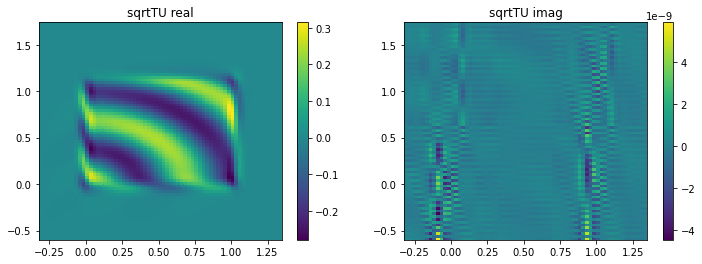

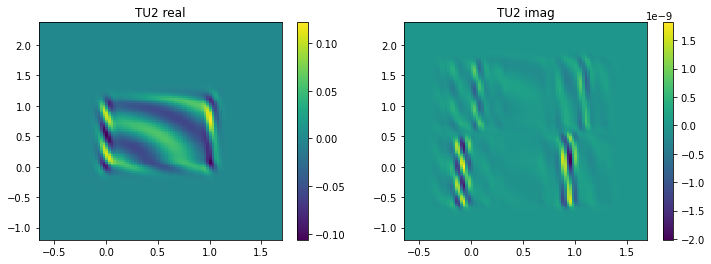

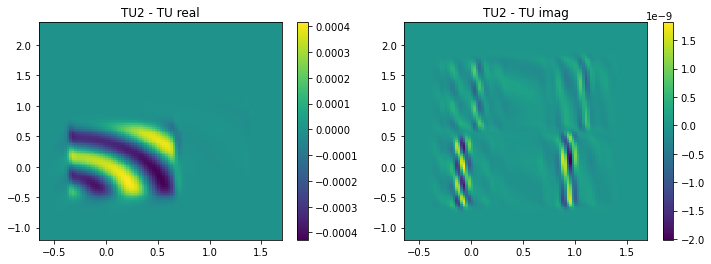

In [11]:
sqrtTU = boxconv(Z, U)

sqrtTU.plot('sqrtTU')

TU2 = boxconv(Z, sqrtTU)

TU2.plot('TU2')

ERR = TU2 - TU

err_sqrt = boxnorm(ERR) / boxnorm(TU)
print('err_sqrt=', err_sqrt)

ERR.plot(title='TU2 - TU')